In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import neo

import numpy as np
import pandas as pd

from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import FloatVector
from rpy2.robjects import pandas2ri
pandas2ri.activate()

import scipy.stats

from collections import Counter

import matplotlib.gridspec as gridspec

import os

from scipy import signal

In [2]:
# ro.r('source("burstanalysis/CMA_method.R")')
# ro.r('source("burstanalysis/hennig_method.R")')
# ro.r('source("burstanalysis/logisi_pasq_method.R")')
# ro.r('source("burstanalysis/PS_method.R")')
# ro.r('source("burstanalysis/RGS_method.R")')
# ro.r('source("burstanalysis/RS_method.R")')
# ro.r('source("burstanalysis/MI_method.R")')

# ro.r(' mi.par <- list(beg.isi =    0.17,  end.isi =    0.3, min.ibi =    0.2, min.durn =   0.01, min.spikes = 3)')

In [3]:
# methods = [('logisi', 'data.frame(logisi.pasq.method(spikes))'), 
#            ('robust surprise', 'data.frame(RS.method(spikes,RS.thresh=4.5))'),
#            ('robust gaussian', 'data.frame(RGS.method(spikes, thresh=4.5))'),
#           ('poisson surprise', 'data.frame(PS.method(spikes,si.thresh=3))'),
#           ('Cumulative moving average', 'data.frame(CMA.method(spikes))'), 
#            ('henning', 'data.frame(hennig.method(spikes))'),
#           ('MI', 'data.frame(MI.method(spikes))')]

In [4]:
def plot_spikes(spikes, burst_spikes, mname, df=None, dname=None):
    isi = spikes[1:] - spikes[:-1]

    cv = scipy.stats.variation(isi)
    ai = np.median(isi)/np.mean(isi)
    
    f, axarr = plt.subplots(2, sharex=True, figsize=(15,10))

    for i in range(spikes.shape[0]):
        axarr[0].plot([spikes[i], spikes[i]], [-1, 1], color='black', lw=0.2)

        if burst_spikes[i] == True:
            axarr[1].plot([spikes[i], spikes[i]], [-1, 1], color='red', lw=0.2)
#             axarr[2].plot([spikes[i], spikes[i]], [-1, 1], color='red', lw=0.5)
#         else:
#             axarr[2].plot([spikes[i], spikes[i]], [-1, 1], color='black', lw=0.5)
    
    if not (df is None):
        for s, e in zip(res['beg'], res['end']):
            s -= 1
            e -= 1

            s, e = int(s), int(e)

            axarr[1].plot([spikes[s], spikes[e]], [-1.1, -1.1], color='green')

    axarr[0].set_ylim([-5, 5])
    axarr[1].set_ylim([-5, 5])
    axarr[0].set_title('{} raw spikes, cv: {}, ai: {}'.format(mname, round(cv, 3), round(ai, 3)))
    axarr[1].set_title('{} burst spikes, {}%'.format(mname, round(100.*sum(burst_spikes)/len(spikes), 3)))

    plt.show()


In [5]:
def spiketrains_iterator(handler):
    for blk in handler.read(cascade=True, lazy=False):
        for seg in blk.segments:
            for st in seg.spiketrains:
                yield st.name, np.array(st)
                
def events_iterator(handler):
    for blk in handler.read(cascade=True, lazy=False):
        for seg in blk.segments:
            for st in seg.events:
                yield st.annotations['channel_name'], np.array(st)

In [6]:
SPIKES_RV = scipy.stats.poisson(1.)

def clever_split(arr, step):
    res = list()
    
    idx = 0
    for l in np.arange(0, arr[~0], step):
        curr = list()
        while(idx < len(arr) and arr[idx] < l + step):
            curr.append(arr[idx])
            idx += 1
        
        res.append(curr)
    
    return res


def calc_discharge_rate(spikes):
    return 1.*len(spikes)/(spikes[~0] - spikes[0])

def bin_by_discharge(spikes, coeff=2):
    return coeff/calc_discharge_rate(spikes)


def median_of_three_smoothing(hist):
#     res = np.array(hist)
#     res[0] = np.median([hist[0], hist[0], hist[1]])
#     for i in range(1, hist.shape[0]-1):
#         res[i] = np.median(hist[i-1:i+2])
#     res[-1] = np.median([hist[-2], hist[-1], hist[-1]])

#     return res
    return scipy.signal.medfilt(hist, 3)


def find_by_bin(hist):
    d = None
    for i in range(1, hist.shape[0] - 1):
        if hist[i] < hist[i-1] and hist[i] <= hist[i+1]:
            d = i
            break

    return d


def find_by_slope(hist):
    d = None
    slope, _, _, _, _ = scipy.stats.linregress(list(range(len(hist))), hist)
    slope = abs(slope)
    for i in range(1, hist.shape[0]):
        if abs(hist[i] - hist[i-1]) < slope:
            d = i
            break

    return d


def find_threshold_density(hist):
    d = find_by_bin(hist)

    if d is None:
        d = find_by_slope(hist)

    if d is None:
        raise 'Wow, cant find density threshold!'

    return d

def calc_bin_isi_std(spikes):
    isi = spikes[1:] - spikes[:-1]
    return np.std(isi)

def detect_with_vitek(spikes, min_spikes=3, bin_func=bin_by_discharge):
    spikes = np.array(spikes)
        
#     t = 1./calc_discharge_rate(spikes)*2
#     t = np.std(sp_isi)
    t = bin_func(spikes)
#     t = 0.015586839995722678
    print('t: {}'.format(round(t, 3)))

    counts = list(map(len, clever_split(spikes, t)))
    nums, vals = zip(*sorted(Counter(counts).items()))
    
#     vals= np.array(vals, dtype=float)
    vals = median_of_three_smoothing(np.array(vals, dtype=float))

    ch2_test = scipy.stats.chisquare(vals, SPIKES_RV.pmf(nums)*len(spikes))[1]
    skew_test = scipy.stats.skew(counts)

    burst_spikes = np.zeros(spikes.shape[0], dtype=bool)
    burst_isi = np.zeros(spikes.shape[0]-1, dtype=bool) 
    
    if(ch2_test < 0.05 and skew_test > 0.5):
        d = find_threshold_density(vals)

        isi_t = t/d
        
        print('isi_t: {}'.format(round(isi_t, 3)))
        isi = np.ediff1d(spikes)
        burst_isi = np.array(isi <= isi_t, dtype=bool)      
        
        prev = 0
        counter = 0
        for idx, i in enumerate(burst_isi):
            if i:
                counter += 1
            else:
                burst_isi[prev:idx] = (counter >= min_spikes - 1)
                burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)
                counter = 0   
                prev = idx + 1
                
        burst_isi[prev:idx] = (counter >= min_spikes - 1)
        burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)
        
        return burst_spikes, burst_isi, vals
    else:
        return np.zeros(spikes.shape[0], dtype=bool), np.zeros(spikes.shape[0]-1, dtype=bool), vals

In [7]:
def detect_plot(nm, st, bin_func_name='discharge'):
    if bin_func_name == 'discharge':
        bin_func = bin_by_discharge
    else:
        bin_func = calc_bin_isi_std
    
    vitek_bursts, burst_isi, hist = detect_with_vitek(st, bin_func=bin_func)
    isi = st[1:] - st[:-1]
    
    fig = plt.figure(figsize=(15,10))
    gridspec.GridSpec(3,3)

    plt.subplot2grid((3, 3), (0,1))
    plt.bar(np.arange(hist.shape[0]), hist)
    plt.plot(SPIKES_RV.pmf(np.arange(hist.shape[0]))*len(st), color='black')
    plt.title('SDH, method: {}'.format(bin_func_name))
    
    plt.subplot2grid((3, 3), (1,0), colspan=3)
    for s in st:
        plt.plot([s, s], [-1, 1], color='black', lw=0.3)
        
    plt.ylim([-5, 5])      
    plt.xlim([-0.5, st[~0] + 0.5])
    plt.title('raw spikes, name: {}'.format(nm))
    
    plt.subplot2grid((3, 3), (2,0), colspan=3)
    for s in st[vitek_bursts]:
        plt.plot([s, s], [-1, 1], color='red', lw=0.3)
        
    for idx, i in enumerate(burst_isi):
        if i:
            plt.plot([st[idx], st[idx+1]], [-1.2, -1.2], color='green')
    
    plt.ylim([-5, 5])
    plt.xlim([-0.5, st[~0] + 0.5])
    plt.title('burst spikes, ai: {}'.format(round(np.median(isi)/np.mean(isi), 3)))    
    
    return vitek_bursts, burst_isi

t: 0.041
isi_t: 0.006
t: 0.041
isi_t: 0.006


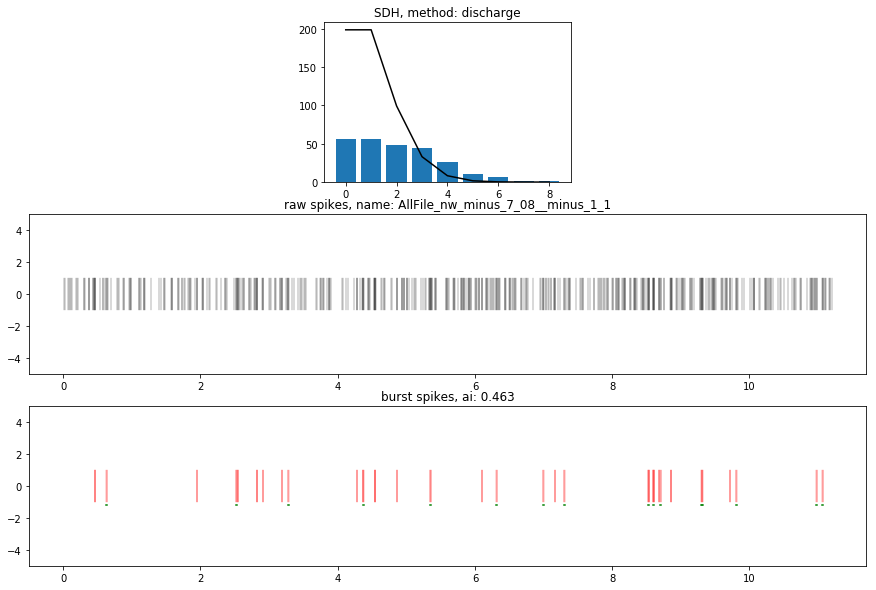

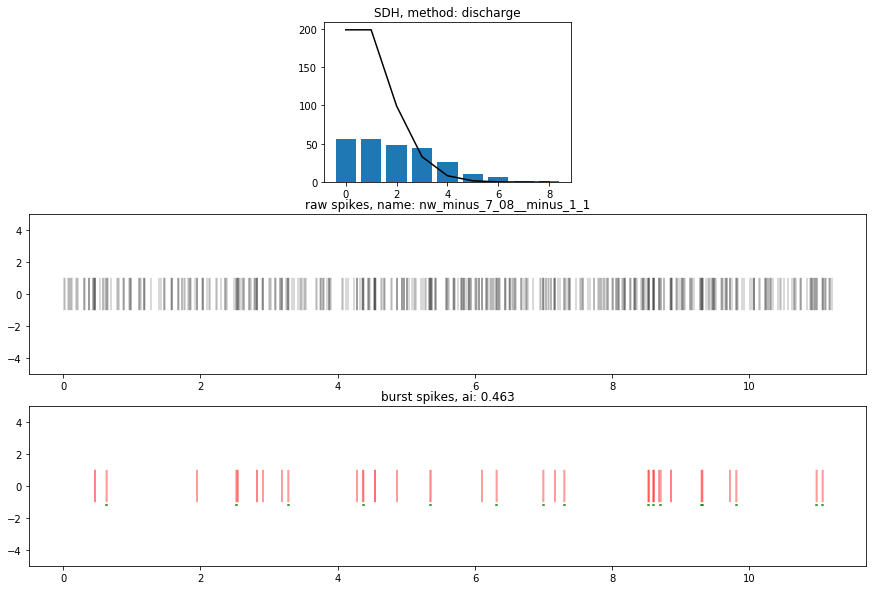

In [8]:
fname = '../neuro_data/pattern_data/LT1D01.28.nex'
r = neo.io.NeuroExplorerIO(fname)

for idxst, (name, spikes) in enumerate(spiketrains_iterator(r)):
    if len(spikes) < 50:
        continue
        
    burst_spikes, burst_isi = detect_plot(name, spikes, 'discharge')
    
    plt.savefig('images/{}_{}_std.png'.format(os.path.split(fname)[~0], name))

In [9]:
isi = spikes[1:] - spikes[:-1]

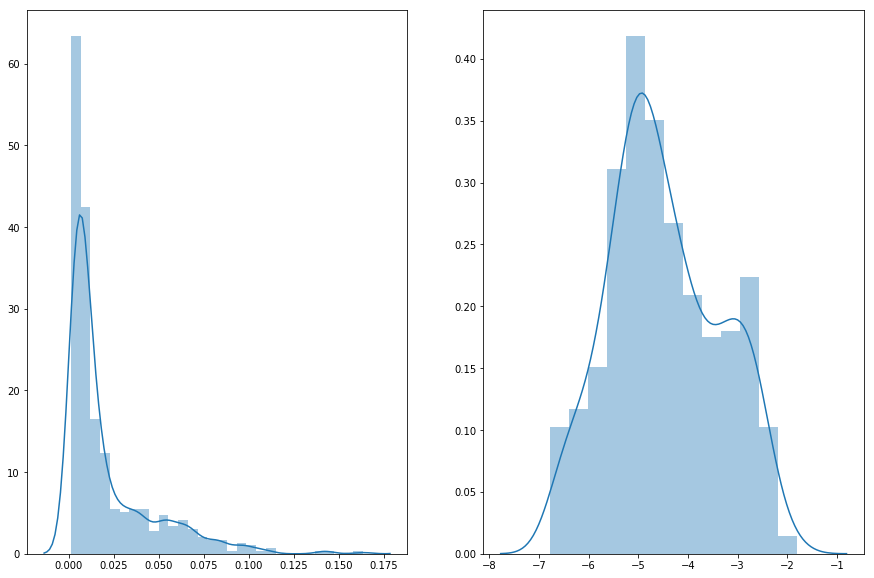

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,10))

sns.distplot(isi, ax=ax1)
sns.distplot(np.log(isi), ax=ax2)

In [20]:
from sklearn.mixture import BayesianGaussianMixture

In [31]:
log_m = BayesianGaussianMixture(n_components=2)
m = BayesianGaussianMixture(n_components=2)

In [32]:
log_m.fit(np.log(isi).reshape((isi.shape[0], 1)))

m = BayesianGaussianMixture(n_components=2)
m.fit(np.log(isi).reshape((isi.shape[0], 1)))

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=100, mean_precision_prior=None, mean_prior=None,
            n_components=2, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [54]:
burst_spikes = np.zeros(spikes.shape[0], dtype=bool)
burst_isi = np.zeros(len(isi_dist), dtype=bool)

min_spikes = 4

prev = 0
counter = 0
for idx, i in enumerate(isi_dist):
    if i == 1:
        counter += 1
    else:
        burst_isi[prev:idx] = (counter >= min_spikes - 1)
        burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)
        counter = 0   
        prev = idx + 1

burst_isi[prev:idx] = (counter >= min_spikes - 1)
burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)

(-5.0, 5.0)

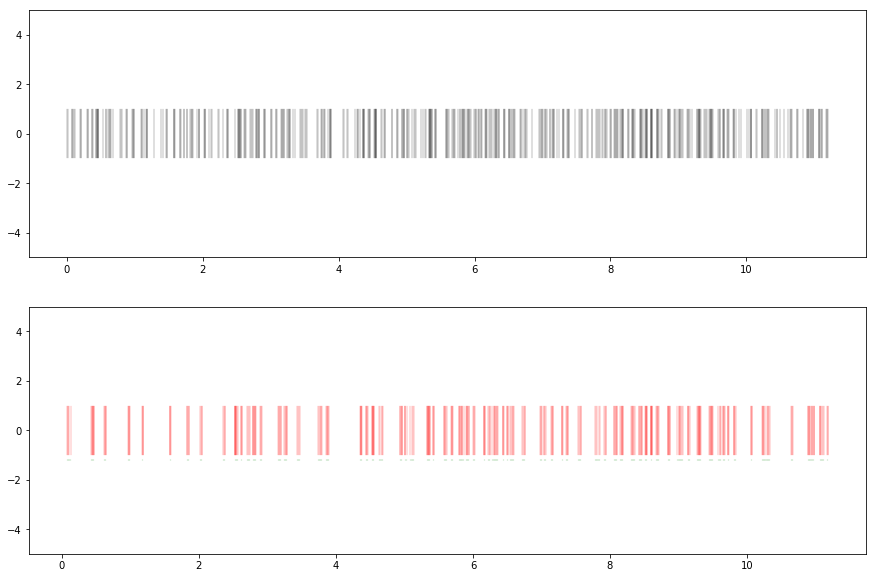

In [55]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,10))

for s in spikes:
    ax1.plot([s, s], [-1, 1.], color='black', lw=0.25)

for s in spikes[burst_spikes]:
    ax2.plot([s, s], [-1, 1.], color='red', lw=0.25)
    
for i in np.nonzero(burst_isi):
    ax2.plot([spikes[i], spikes[i+1]], [-1.2, -1.2], color='green', lw=0.25)

ax1.set_ylim([-5., 5.])
ax2.set_ylim([-5., 5.])

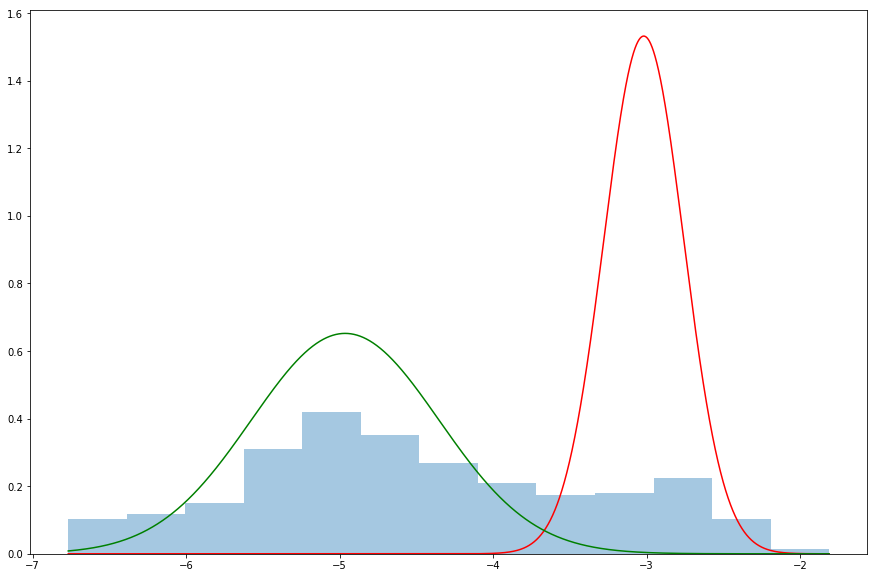

In [52]:
fig, ax1 = plt.subplots(figsize=(15,10))

log_axis = np.arange(min(np.log(isi)), max(np.log(isi)), 0.001)
    
for idx, (mean, d) in enumerate(zip(log_m.means_, log_m.covariances_)):
    ax1.plot(log_axis, scipy.stats.norm.pdf(log_axis, mean, d[0]), color=cols[idx])

sns.distplot(np.log(isi), ax=ax1, kde=False, norm_hist=True)

In [56]:
m.means_, m.covariances_

(array([[-4.95696534],
        [-3.00862137]]), array([[[ 0.61870205]],
 
        [[ 0.25502507]]]))

In [76]:
np.log(isi[np.logical_not(isi_dist == log_m.predict(np.log(isi).reshape((isi.shape[0], 1))))])

array([-3.66375758])

In [79]:
[normpdf(-3.66375758, mean, sd[0]) for mean, sd in zip(log_m.means_, log_m.covariances_)]

[0.07091174078978002, 0.068108473553414303]

In [58]:
# tvals = list()
# dvals = list()

# for t in np.linspace(min(isi), max(isi), 25):
#     counts = list(map(len, clever_split(spikes, t)))
#     nums, vals = zip(*sorted(Counter(counts).items()))

#     hist = median_of_three_smoothing(np.array(vals, dtype=float))
# #     hist = np.array(vals, dtype=float)

#     d = None
#     for i in range(1, hist.shape[0] - 1):
#         if hist[i] < hist[i-1] and hist[i] <= hist[i+1]:
#             d = hist[i-1] - hist[i] + hist[i+1] - hist[i]
#             break
    
#     if d is None:
#         d = -1.
        
#     f = plt.figure()
#     plt.bar(nums, hist)
#     plt.title('bin: {}'.format(round(t, 3)))
    
#     tvals.append(t)  
#     dvals.append(d)
    
#     f.savefig('{}.png'.format(round(t, 3)))
        

In [87]:
def JSD(P, Q):
    _P = P / np.linalg.norm(P, ord=1)
    _Q = Q / np.linalg.norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (scipy.stats.entropy(_P, _M) + scipy.stats.entropy(_Q, _M))

def model_diff(m, logisi):    
    x_axis = np.arange(np.min(logisi), np.max(logisi), 0.001)
    
    d1 = scipy.stats.norm.pdf(x_axis, m.means_[0], m.covariances_[0][0])
    d2 = scipy.stats.norm.pdf(x_axis, m.means_[1], m.covariances_[1][0])
    
    return JSD(d1, d2)

C:\Users\vladka\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


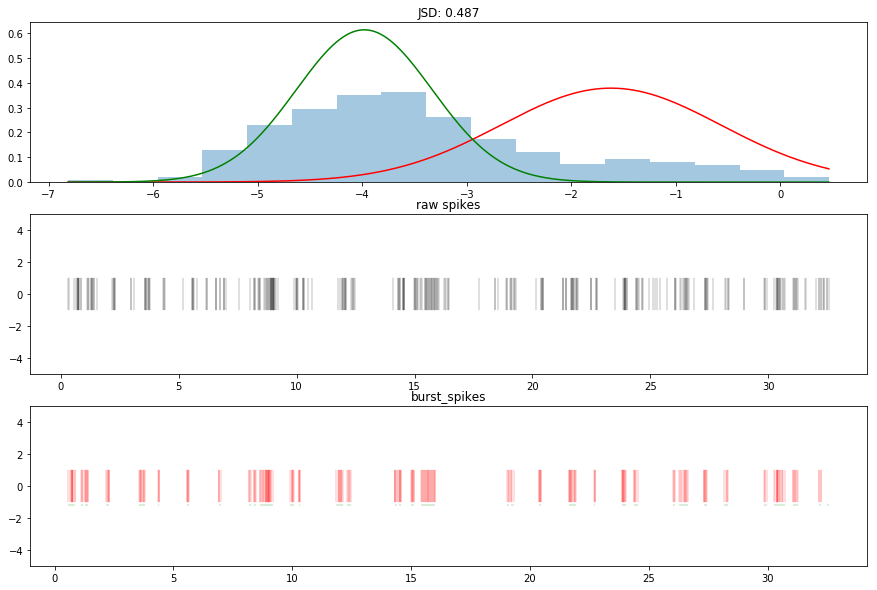

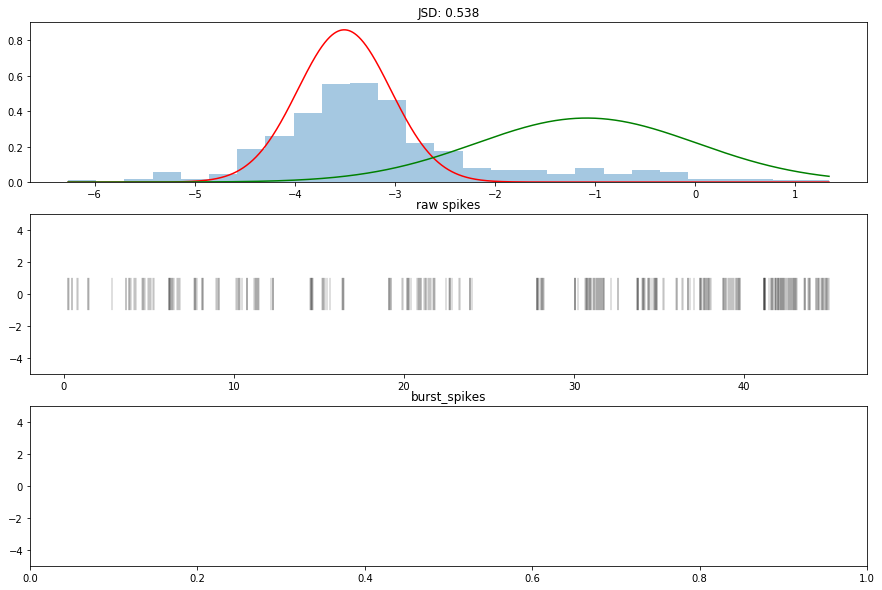

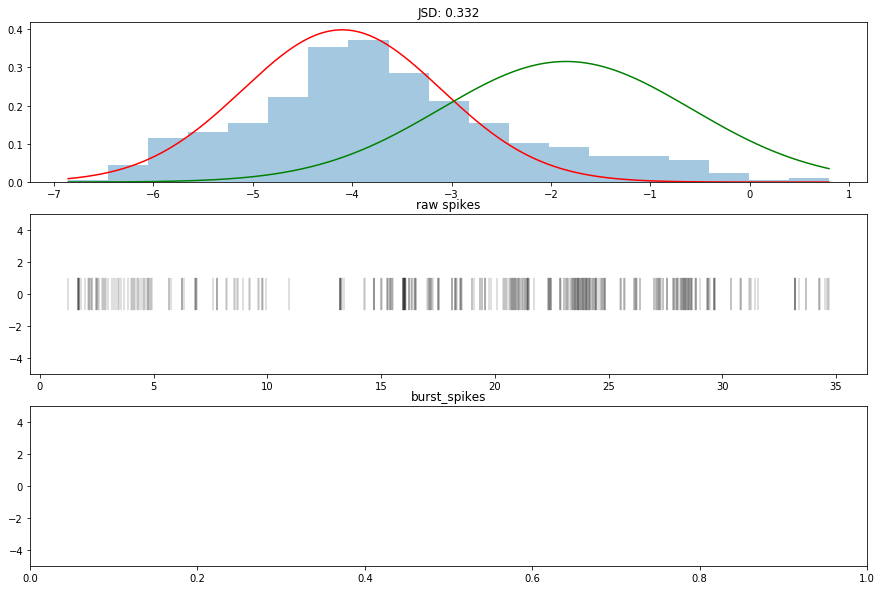

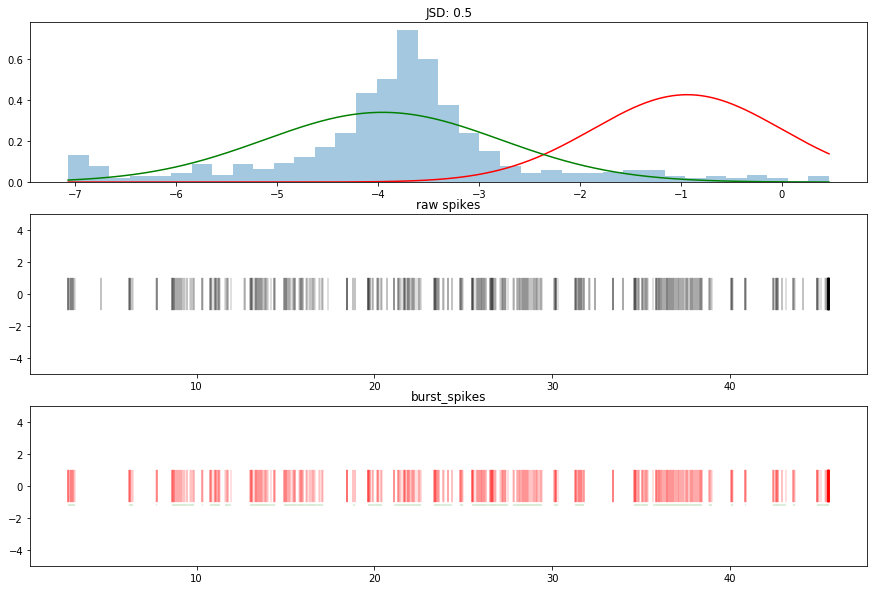

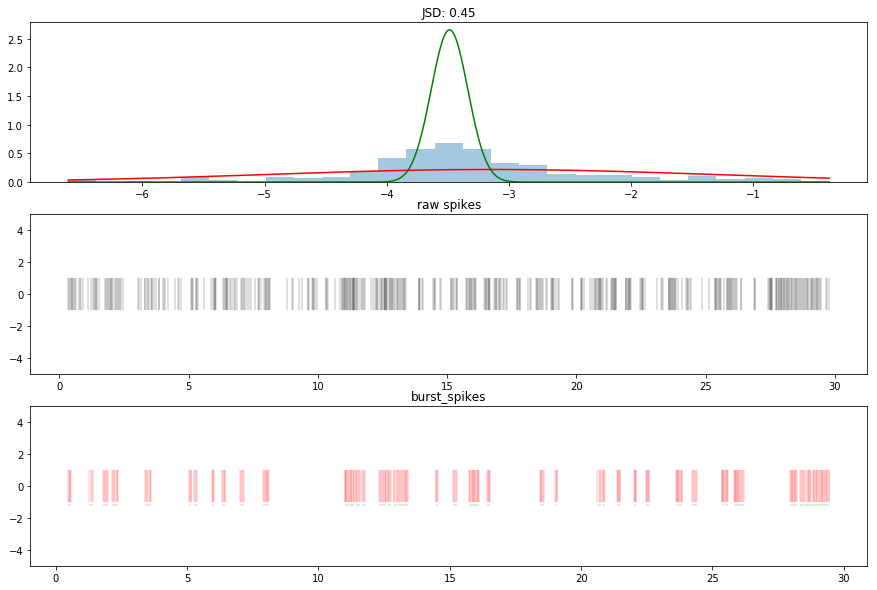

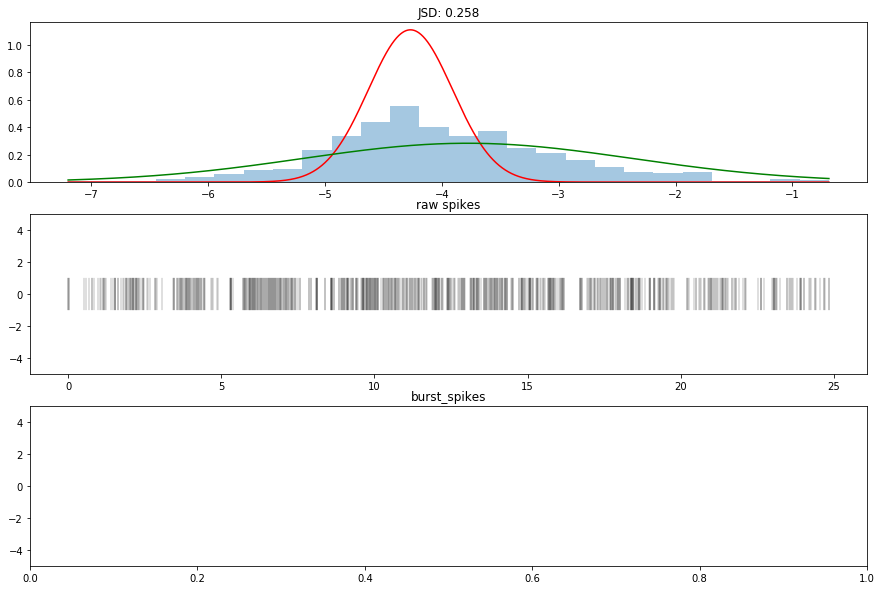

In [108]:
fname = '../neuro_data/pattern_data/All_cells.nex'
r = neo.io.NeuroExplorerIO(fname)

bad_st = list()
bad_logisi = list()

for idxst, (name, spikes) in enumerate(events_iterator(r)):
    if idxst > 5:
        break

    if len(spikes) < 50:
        continue
        
    isi = spikes[1:] - spikes[:-1]
    logisi = np.log(isi[np.nonzero(isi)]).reshape((isi.shape[0], 1))
    
    m = BayesianGaussianMixture(n_components=2)
    m.fit(logisi)
    
    score = model_diff(m, logisi)   
    
    burst_isi = np.zeros(isi.shape[0], dtype=bool)
    burst_spikes = np.zeros(spikes.shape[0], dtype=bool)
    
    if m.converged_ and score > 0.4:
        burst_isi = m.predict(logisi)  
        min_spikes = 4

        prev = 0
        counter = 0
        for idx, i in enumerate(burst_isi):
            if i == 1:
                counter += 1
            else:
                burst_isi[prev:idx] = (counter >= min_spikes - 1)
                burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)
                counter = 0   
                prev = idx + 1

        burst_isi[prev:idx] = (counter >= min_spikes - 1)
        burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)
    
    fig, (ax3, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,10))
    
    sns.distplot(logisi, ax=ax3, kde=False, norm_hist=True)
    log_axis = np.arange(np.min(logisi), np.max(logisi), 0.001)
    
    for idx, (mean, d) in enumerate(zip(m.means_, m.covariances_)):
        ax3.plot(log_axis, scipy.stats.norm.pdf(log_axis, mean, d[0]), color=cols[idx])
    

    for s in spikes:
        ax1.plot([s, s], [-1, 1.], color='black', lw=0.25)

    for s in spikes[burst_spikes]:
        ax2.plot([s, s], [-1, 1.], color='red', lw=0.25)

    for i in np.nonzero(burst_isi)[0]:
        ax2.plot([spikes[i], spikes[i+1]], [-1.2, -1.2], color='green', lw=0.25) 
    
    if score < 0.4:
        bad_logisi.append(logisi)
        bad_st.append(spikes)
    
    ax1.set_ylim([-5., 5.])
    ax2.set_ylim([-5., 5.])
    
    ax3.set_title('JSD: {}'.format(round(score, 3)))
    ax1.set_title('raw spikes')
    ax2.set_title('burst_spikes')

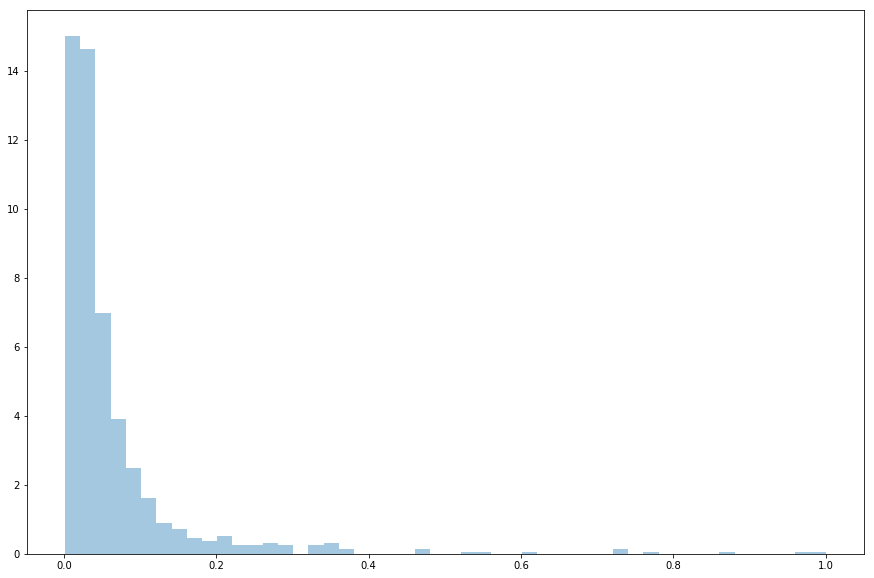

In [124]:
plt.figure(figsize=(15,10))
sns.distplot(isi/np.max(isi), kde=False, norm_hist=True)

In [15]:
def axvlines(xs, ax=None, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    if ax is None:
        lims = plt.gca().get_ylim()
    else:
        lims = ax.get_ylim()

    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    
    if ax is None:
        plot = plt.plot(x_points, y_points, scaley = False, **plot_kwargs)
    else:
        plot = ax.plot(x_points, y_points, scaley = False, **plot_kwargs)

    return plot

(-5, 5)

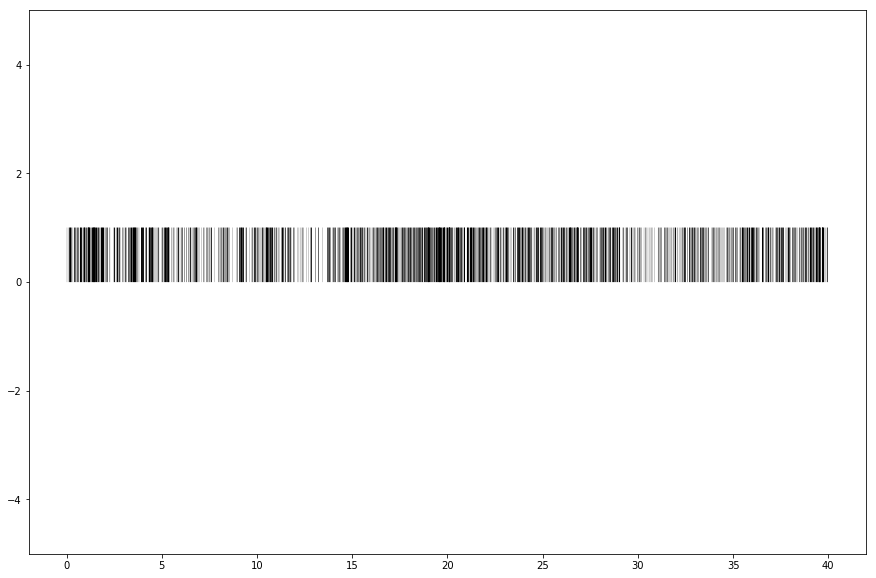

In [133]:
plt.figure(figsize=(15,10))
axvlines(spikes, lw=0.2, color='black')

plt.ylim([-5, 5])

In [165]:
def moving_burst(spikes, wlen=20, threshold=.5):
    isi = spikes[1:] - spikes[:-1]
    global_mean = np.mean(isi)
    
    isi_vis = np.zeros(isi.shape[0], dtype=int)
    isi_t = np.zeros(isi.shape[0], dtype=float)
    
    for i in range(isi.shape[0] - wlen + 1):
        isi_vis[i:i+wlen] += 1
        
        m = np.mean(isi[i:i+wlen])
        isi_t[i:i+wlen] += (isi[i:i+wlen] <= m)
    
    isi_t /= isi_vis
        
    burst_isi = np.array(isi_t >= threshold)
    burst_spikes = np.zeros(spikes.shape[0], dtype=bool)
    
    prev = 0
    counter = 0
    for idx, i in enumerate(burst_isi):
        if i:
            counter += 1
        else:
            burst_isi[prev:idx] = (counter >= min_spikes - 1)
            burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)
            counter = 0   
            prev = idx + 1

    burst_isi[prev:idx] = (counter >= min_spikes - 1)
    burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)
    
    return burst_spikes, burst_isi

In [166]:
bspikes, bisi = moving_burst(spikes)

(-2, 3)

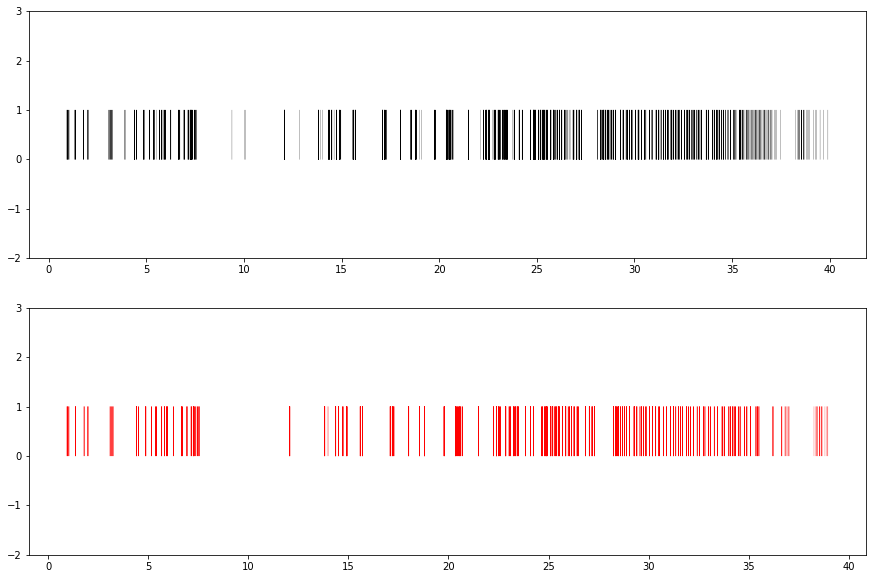

In [169]:
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,10))

axvlines(spikes, ax=ax1, lw=0.25, color='black')
ax1.set_ylim([-2, 3])

axvlines(spikes[bspikes], ax=ax2, lw=0.25, color='red')
ax2.set_ylim([-2, 3])

In [56]:
spikes = spikes - spikes[0]

inter_step = 0.05
isi_steps = np.arange(0, (spikes[~0] - spikes[0]), inter_step)
isi_func = np.zeros(int(np.ceil((spikes[~0] - spikes[0])/inter_step)))

for idx in range(1, len(spikes)):
    l, r = int(round(spikes[idx-1]/inter_step)), int(round(spikes[idx]/inter_step))
    isi_func[l:r] = spikes[idx] - spikes[idx - 1]
#     print(idx, s)

In [57]:
isi_func.shape, isi_steps.shape

((82,), (82,))

0 0
0 5
5 7
7 8
8 8
8 8
8 9
9 9
9 9
9 9
9 9
9 11
11 11


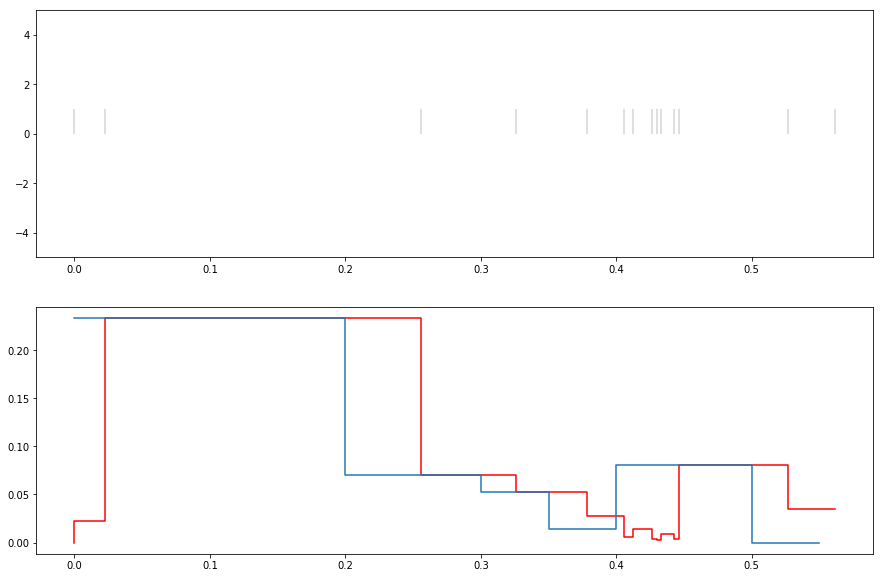

In [60]:
fname = '../neuro_data/pattern_data/All_cells.nex'
r = neo.io.NeuroExplorerIO(fname)


for idxst, (name, spikes) in enumerate(events_iterator(r)):
    if len(spikes) < 50:
        continue
        
    spikes = spikes[spikes <= 1]
    spikes = spikes - spikes[0]
    
    inter_step = 0.05
    isi_steps = np.arange(0, (spikes[~0] - spikes[0]), inter_step)
    isi_func = np.zeros(int(np.ceil((spikes[~0] - spikes[0])/inter_step)))
            
    f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,10))

    axvlines(spikes, ax=ax1, lw=0.25, color='black')
    ax1.set_ylim([-5, 5])
    
    ax2.step(spikes, [0] + np.array(spikes[1:] - spikes[:-1]).tolist(), color='red')

    ax2.set_xlim(ax1.get_xlim())
    ax2.step(isi_steps, isi_func)
    
    break

In [11]:
# fname = '../neuro_data/pattern_data/All_cells.nex'
# r = neo.io.NeuroExplorerIO(fname)

# bad_st = list()
# bad_logisi = list()

# for idxst, (name, spikes) in enumerate(events_iterator(r)):
#     if len(spikes) < 50:
#         continue
        
#     bspikes, bisi = moving_burst(spikes)
    
#     f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,10))

#     axvlines(spikes, ax=ax1, lw=0.25, color='black')
#     ax1.set_ylim([-5, 5])

#     axvlines(spikes[bspikes], ax=ax2, lw=0.25, color='red')
#     ax2.set_ylim([-5, 5])
#     ax2.set_xlim(ax1.get_xlim())

In [59]:
# plt.figure()

# for s in spikes[burst_spikes]:
#     plt.plot([s, s], [-1, 1], color='red', lw=0.3)

# for i in np.nonzero(burst_isi)[0]:
#     plt.plot([spikes[i], spikes[i+1]], [-1.2, -1.2], color='green')

In [ ]:
np.matmul()

In [60]:
# fname = 'pattern_data/LT1D01.28.nex'
# r = neo.io.NeuroExplorerIO(fname)

# for idxst, (name, spikes) in enumerate(spiketrains_iterator(r)):
#     if len(spikes) < 50:
#         continue
        
#     burst_isi, burst_spikes = detect_plot(name, spikes, 'isi_std')
    
#     plt.savefig('images/{}_{}_std.png'.format(os.path.split(fname)[~0], name))

In [61]:
# fname = 'pattern_data/All_cells.nex'
# r = neo.io.NeuroExplorerIO(fname)

# for idxst, (name, spikes) in enumerate(events_iterator(r)):
#     if len(spikes) < 50:
#         continue
        
#     burst_isi, burst_spikes = detect_plot(name, spikes, 'discharge')
    
#     plt.savefig('images/{}_{}_double.png'.format(os.path.split(fname)[~0], name))

In [62]:
# fname = 'pattern_data/All_cells.nex'
# r = neo.io.NeuroExplorerIO(fname)

# for idxst, (name, spikes) in enumerate(events_iterator(r)):
#     if len(spikes) < 50:
#         continue
        
#     burst_isi, burst_spikes = detect_plot(name, spikes, 'isi_std')
    
#     plt.savefig('images/{}_{}_std.png'.format(os.path.split(fname)[~0], name))

In [13]:
# fname = 'pattern_data\\LT2D-0.225t.nex'
# r = neo.io.NeuroExplorerIO(fname)

# for st in spiketrains_iterator(r):
#     nm = st.name
#     if len(st) < 50:
#         continue
        
#     st = np.array(st)
#     spikes_r = ro.FloatVector(st)

#     for mname, mfunc in methods:
#         print(mname)

#         ro.r.assign('spikes', spikes_r)
#         res = pd.DataFrame(ro.r(mfunc))

#         burst_spikes = np.zeros(len(st))
        
#         if 'end' not in res:
#             res['end'] = res['beg'] + res['len'] - 1
            
#         try:
#             idx = zip(map(int, res['beg']), map(int, res['end']))

#             for s, e in idx:
#                 s -= 1
#                 e -= 1
                
#                 burst_spikes[s:e] = True
#         except:
#             pass
        
#         plot_spikes(st, burst_spikes, mname, res, dname=nm)

In [121]:
q = [13, 14, 8, 10, 16, 26, 32, 27, 18, 32, 36, 24, 22, 23, 22, 18, 25, 21, 21, 14, 8, 11, 14, 23, 18, 17, 19, 20, 22, 19, 13, 26, 13, 14, 22, 24, 21, 22, 26, 21, 23, 24, 27, 41, 31, 27, 35, 26, 28, 36, 39, 21, 17, 22, 17, 19, 15, 34, 10, 15, 22, 18, 15, 20, 15, 22, 19, 16, 30, 27, 29, 23, 20, 16, 21, 21, 25, 16, 18, 15, 18, 14, 10, 15, 8, 15, 6, 11, 8, 7, 18, 16, 13, 12, 13, 20, 15, 16, 12, 18, 15, 16, 13, 15, 16, 11, 11]

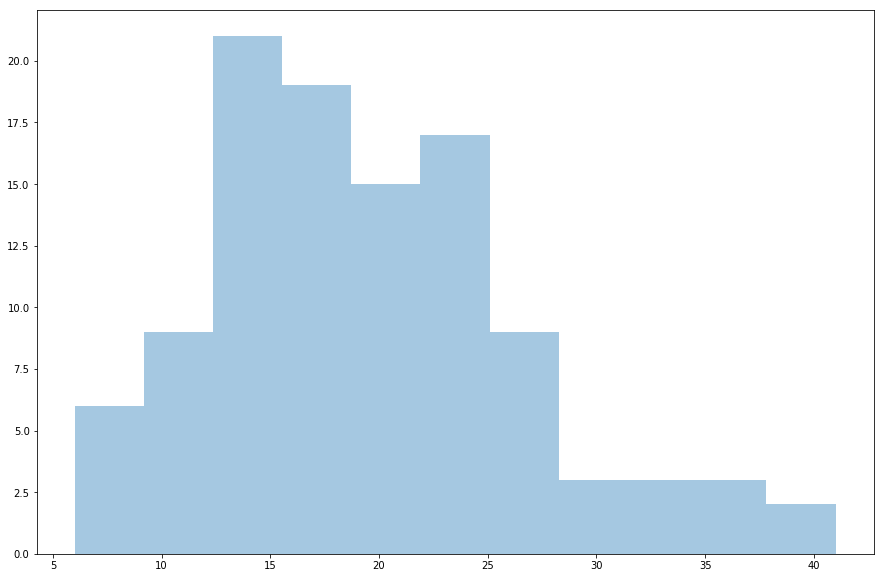

In [123]:
plt.figure(figsize=(15,10))
sns.distplot(q, kde=False)